# TODO  
## Write C functions (tv_denoise, tv_denoise_core, tv_denoise_core_org)  
## Understand the difference between tv_denoise_core, tv_denoise_core_org  
## Add legends to the pics
## ...

In [46]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import matplotlib
# import visvis as vv
%matplotlib inline

In [47]:
def ddot_(vector_a, vector_b):
    if len(vector_a) != len(vector_b):
        raise Exception('Dimention of vectors is not equal')
    return np.dot(vector_a, vector_b)

In [48]:
ddot_([1, 2, 3], [1, 1, 1])

6

In [49]:
def dnrm2_(vector):
    return np.linalg.norm(vector)

In [50]:
dnrm2_(np.array([1, 2, 3]))

3.7416573867739413

In [51]:
def daxpy_(vector_a, vector_b, alpha):
    vector_a = alpha * np.array(vector_b) + np.array(vector_a)
    return vector_a

In [52]:
daxpy_([1, 2, 3], [1, 1, 1], 2)

array([3, 4, 5])

# Some funcs from tools.c that we use (done)

In [72]:
#matlab function
def TVdenoise(noisy_image, delta, eps_rel = 10e-3):
    """
    noisy image - np array !!!
    delta = tau * sqrt(M * N) * sigma
        -tau - less than 1 (0.85 in paper)
        -M, N - size of immage
        -sigma - std of the noise in the pixel
    eps_rel - relative accuracy 1e-3 by default
    """
    alpha = np.sum(noisy_image.flatten()) / len(noisy_image)
    X = alpha * np.ones(noisy_image.shape)
    mdelta = np.linalg.norm(X - noisy_image, 'fro')
    if mdelta < delta:
        #maybe put some info here like in paper
        return
    elif mdelta < 1.1 * delta:
        #maybe throw warning like in paper
        print('Convergence problems may arise')
    R = max(noisy_image.flatten())
    mn = noisy_image.shape[0] * noisy_image.shape[1]
    epsilon = R * mn * eps_rel
    mu = epsilon / mn
    Lmu = 8 / mu
    N = np.ceil(2 * np.sqrt(8 * mn) * delta / epsilon).astype(int) # maxiter as far as I understood
    print(N)
    X = tv_denoise(noisy_image, delta, epsilon, Lmu, mu, N, 0) # rewrite C func!!!!
    return X

# TVdenoise main part in Matlab is done but C function has to be written!!

In [54]:
image = read_image('Pirate.tif')

In [55]:
image.shape

(512, 512)

In [56]:
def create_noisy_image(image, noise_std):
    noisy_image = image + noise_std * np.random.randn(image.shape[0], image.shape[1])
    for row in range(noisy_image.shape[0]): # the larger picture the longer computations!
        for column in range(noisy_image.shape[1]):
            noisy_image[row][column] = max(noisy_image[row][column], 0) # clip outliers
            noisy_image[row][column] = min(noisy_image[row][column], 255)
    return noisy_image

In [57]:
def plot_image(image):
    plt.figure(figsize = (10, 10))
    plt.imshow(image, cmap = 'gray')

In [58]:
noisy_image = create_noisy_image(image, 25)

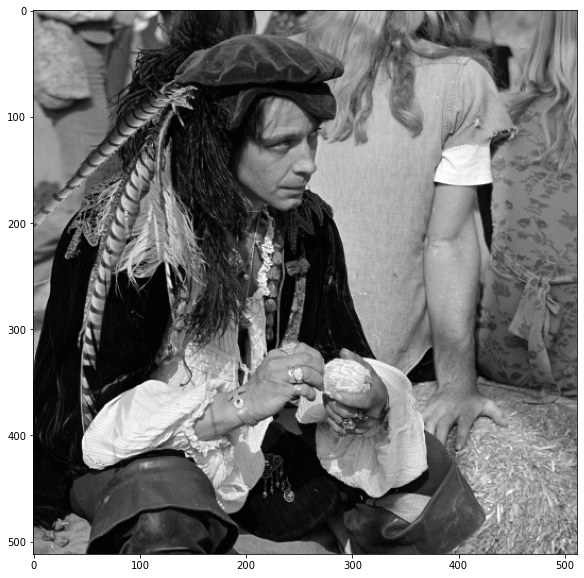

In [59]:
plot_image(image)

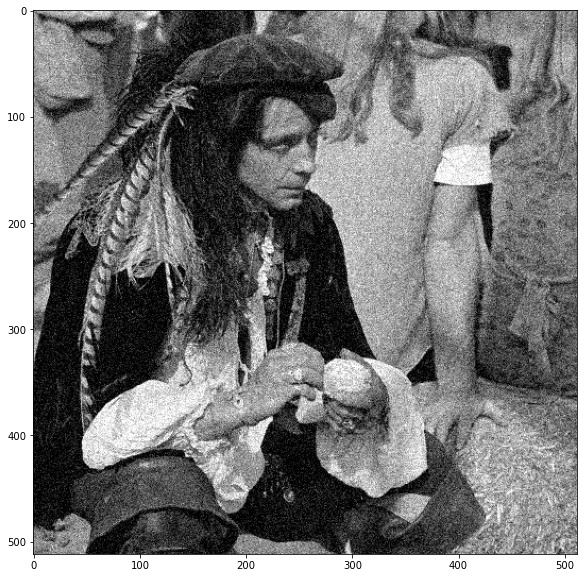

In [60]:
plot_image(noisy_image)

In [75]:
def TVdenoise_demo(image_path, noise_std, tau):
    image = read_image(image_path)
    create_noisy_image(image, noise_std)
    plot_image(image)
    plot_image(noisy_image)
    delta = tau * np.sqrt(noisy_image.shape[0] * noisy_image.shape[1]) * noise_std
    denoised_image = TVdenoise(noisy_image, delta) # rewrite C func! may be add info parameter like in paper
    denoised_image = denoised_image.reshape((512, 512)) # do M x N
    #actually TVdenoise is done, but it has C function insude, that should be rewritten
    plot_image(denoised_image)

In [76]:
def tv_denoise(noisy_img, delta, eps, L, mu, maxiter, typpe): # typpe = type in order to not to use keyword, in paper type = 0
    """
    Just stupid rewrite the C code, but thees three params should be returned from core func
    """
    x = np.zeros(noisy_img.shape)
    kf = 0
    epsilon_kf = 0
    m = noisy_img.shape[0]
    n = noisy_img.shape[1]
    noisy_img = noisy_img.flatten()
    if typpe == 1:
        restored_img = tv_denoise_core(x, noisy_img, delta, eps, L, mu, m, n, maxiter, kf, epsilon_kf)
        return restored_img
    else:
        restored_img = tv_denoise_core_org(x, noisy_img, delta, eps, L, mu, m, n, maxiter, kf, epsilon_kf)
        return restored_img


In [77]:
def tv_denoise_core_org(x, noisy_img, delta, eps, L, mu, m, n, maxiter, kf, epsilon_kf):
        pobj = 0
        dobj = 0
        mn = m * n
        one = 1
        mL = -L
        A_kp1 = 0.5

        wk = np.zeros(mn)
        x = noisy_img.flatten()
        uij = np.zeros(2)
        for k in range(maxiter):
            print(f'{k} iteration')
            df = np.zeros(mn)
            pobj = 0
            # step1
            for j in range(n - 1):
                for i in range(m - 1):
                    i1 = (i + 1) + j * m
                    i2 = i + (j + 1) * m
                    i3 = i + j * m
                    uij[0] = x[i1] - x[i3]
                    uij[1] = x[i2] - x[i3]
                    
                    c1 = np.sqrt(uij[0] * uij[0] + uij[1] * uij[1])
                    pobj += c1
                    
                    c2 = max(mu, c1)
                    uij[0] = uij[0] / c2
                    uij[1] = uij[1] / c2
                    
                    df[i1] += uij[0]
                    df[i3] -= uij[0]
                    df[i2] += uij[1]
                    df[i3] -= uij[1]
                    
            dobj = df.dot(noisy_img) - delta * np.linalg.norm(df)
            if pobj - dobj < eps:
                break
        #step 2
            y_k = (L * (x - noisy_img) - df)/ (max(L, np.linalg.norm(L * (x - noisy_img) - df) / delta)) + noisy_img
        #step3
            wk += ((k + 1) / 2) * df
            zk = wk / max(L, np.linalg.norm(wk) / delta) + noisy_img
        #step4
            x = 2 /(k + 3) *zk + (k + 1)/(k + 3) * y_k
        return x

48
0 iteration
1 iteration
2 iteration
3 iteration
4 iteration
5 iteration
6 iteration
7 iteration
8 iteration
9 iteration
10 iteration
11 iteration
12 iteration
13 iteration
14 iteration
15 iteration
16 iteration
17 iteration
18 iteration
19 iteration
20 iteration
21 iteration
22 iteration
23 iteration
24 iteration
25 iteration
26 iteration
27 iteration
28 iteration
29 iteration
30 iteration
31 iteration
32 iteration
33 iteration
34 iteration
35 iteration
36 iteration
37 iteration
38 iteration
39 iteration
40 iteration
41 iteration
42 iteration
43 iteration
44 iteration
45 iteration
46 iteration
47 iteration


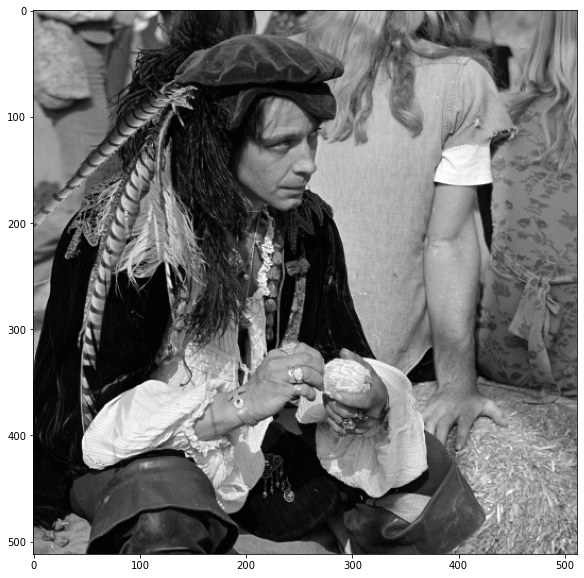

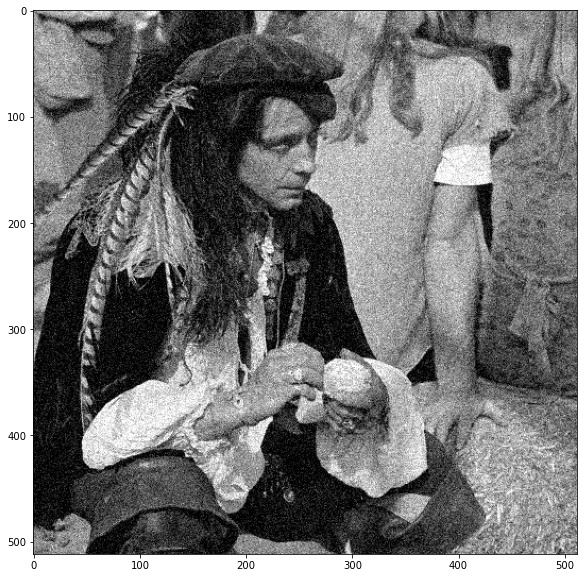

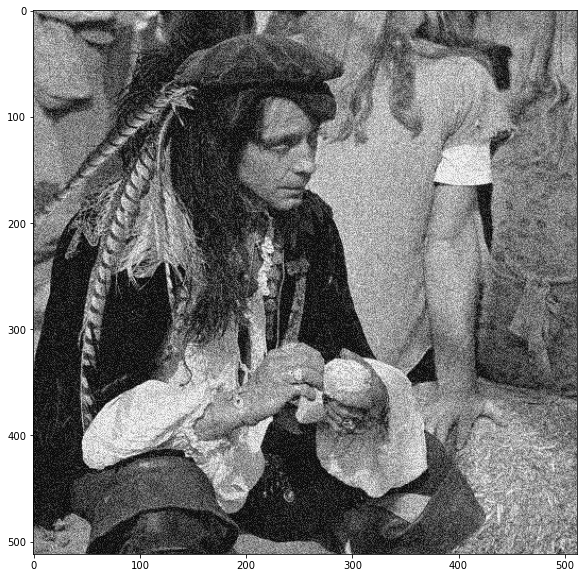

In [78]:
TVdenoise_demo('Pirate.tif', 25, 0.85) # add legends to  pictures!!!

# TVdenoise_demo matlab script from paper (done)

# tv_denoise.c  более менее переписана, но подумать о том, как возвращать значения

# tv_denoise_core_org.c